## ANALYSIS

In [360]:
%load_ext autoreload
%autoreload 2
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
RESULT_JSON = "/Users/law/repos/viper/results/all_ops/full_all_ops.json"

In [366]:
import json

results_raw = json.loads(open(RESULT_JSON).read())
# assert results_raw["context"]["library_build_type"] != "debug"
BENCHMARKS =  results_raw["benchmarks"]
# print(BENCHMARKS)

In [367]:
from collections import defaultdict
runs = defaultdict(list)


ALL_FIXTURES = [VIPER, ROCKS, PMEMKV, DRAM_MAP, HYBRID_FASTER, NVM_FASTER]
ALL_BM_TYPES = ['insert', 'get', 'update', 'delete']

def get_bm_type(bm_type_str):
    for t in ALL_BM_TYPES:
        if t in bm_type_str:
            return t
    raise RuntimeError(f"Unknown bm_type: {bm_type_str}")

for bm in BENCHMARKS:
    found = False
    for (fixture, _) in ALL_FIXTURES:
        bm_type = get_bm_type(bm['name'])
        if fixture in bm['name']:
            runs[(fixture, bm_type)].append(bm)
            found = True
            break
#     if not found: raise RuntimeError(f"Unknown fixture {bm['name']}")

for fixture, _ in ALL_FIXTURES:
    for bm_type in ALL_BM_TYPES:
        runs[(fixture, bm_type)].sort(key=lambda x: x['threads'])

pprint(runs)

defaultdict(<class 'list'>,
            {('DramMap', 'delete'): [{'cpu_time': 39972481.332,
                                      'found': 39711359.0,
                                      'items_per_second': 990957.9328527142,
                                      'iterations': 1,
                                      'name': 'DramMapFixture<KeyType16,ValueType200>/delete/100000000/50000000/iterations:1/repeats:1/real_time/threads:1',
                                      'real_time': 40073708.160023674,
                                      'repetition_index': 0,
                                      'repetitions': 1,
                                      'run_name': 'DramMapFixture<KeyType16,ValueType200>/delete/100000000/50000000/iterations:1/repeats:1/real_time/threads:1',
                                      'run_type': 'iteration',
                                      'threads': 1,
                                      'time_unit': 'us'},
                                     {

                                     {'cpu_time': 1060595.2738437497,
                                      'found': 50000000.0,
                                      'items_per_second': 47025611.37070268,
                                      'iterations': 32,
                                      'name': 'DramMapFixture<KeyType16,ValueType200>/update/100000000/50000000/iterations:1/repeats:1/real_time/threads:32',
                                      'real_time': 33226.57493345105,
                                      'repetition_index': 0,
                                      'repetitions': 1,
                                      'run_name': 'DramMapFixture<KeyType16,ValueType200>/update/100000000/50000000/iterations:1/repeats:1/real_time/threads:32',
                                      'run_type': 'iteration',
                                      'threads': 32,
                                      'time_unit': 'us'},
                                     {'cpu_time': 1102525

                                        'run_type': 'iteration',
                                        'threads': 36,
                                        'time_unit': 'us'}],
             ('NvmFaster', 'get'): [{'cpu_time': 114625251.54399998,
                                     'found': 50000001.0,
                                     'items_per_second': 435109.2373236087,
                                     'iterations': 1,
                                     'name': 'NvmFasterFixture<KeyType16,ValueType200>/get/100000000/50000000/iterations:1/repeats:1/real_time/threads:1',
                                     'real_time': 114913673.88004437,
                                     'repetition_index': 0,
                                     'repetitions': 1,
                                     'run_name': 'NvmFasterFixture<KeyType16,ValueType200>/get/100000000/50000000/iterations:1/repeats:1/real_time/threads:1',
                                     'run_type': 'iteration',
 

                                        'real_time': 5105577.663326585,
                                        'repetition_index': 0,
                                        'repetitions': 1,
                                        'run_name': 'NvmFasterFixture<KeyType16,ValueType200>/update/100000000/50000000/iterations:1/repeats:1/real_time/threads:8',
                                        'run_type': 'iteration',
                                        'threads': 8,
                                        'time_unit': 'us'},
                                       {'cpu_time': 39656051.063812494,
                                        'found': 50000000.0,
                                        'items_per_second': 1252033.94748239,
                                        'iterations': 16,
                                        'name': 'NvmFasterFixture<KeyType16,ValueType200>/update/100000000/50000000/iterations:1/repeats:1/real_time/threads:16',
                                

                                            'items_per_second': 1482409.9488719031,
                                            'iterations': 24,
                                            'name': 'PmemHybridFasterFixture<KeyType16,ValueType200>/get/100000000/50000000/iterations:1/repeats:1/real_time/threads:24',
                                            'real_time': 1405369.683052514,
                                            'repetition_index': 0,
                                            'repetitions': 1,
                                            'run_name': 'PmemHybridFasterFixture<KeyType16,ValueType200>/get/100000000/50000000/iterations:1/repeats:1/real_time/threads:24',
                                            'run_type': 'iteration',
                                            'threads': 24,
                                            'time_unit': 'us'},
                                           {'cpu_time': 33781178.98274999,
                                      

                                     'time_unit': 'us'},
                                    {'cpu_time': 99663660.54099996,
                                     'found': 39710449.0,
                                     'items_per_second': 397501.8292211615,
                                     'iterations': 8,
                                     'name': 'PmemKVFixture<KeyType16,ValueType200>/delete/100000000/50000000/iterations:1/repeats:1/real_time/threads:8',
                                     'real_time': 12487505.113437464,
                                     'repetition_index': 0,
                                     'repetitions': 1,
                                     'run_name': 'PmemKVFixture<KeyType16,ValueType200>/delete/100000000/50000000/iterations:1/repeats:1/real_time/threads:8',
                                     'run_type': 'iteration',
                                     'threads': 8,
                                     'time_unit': 'us'},
                  

                                     'run_name': 'PmemKVFixture<KeyType16,ValueType200>/insert/100000000/50000000/iterations:1/repeats:1/real_time/threads:32',
                                     'run_type': 'iteration',
                                     'threads': 32,
                                     'time_unit': 'us'},
                                    {'cpu_time': 62199390.14075001,
                                     'found': 50000000.0,
                                     'items_per_second': 798423.9005587798,
                                     'iterations': 36,
                                     'name': 'PmemKVFixture<KeyType16,ValueType200>/insert/100000000/50000000/iterations:1/repeats:1/real_time/threads:36',
                                     'real_time': 1739538.3567901477,
                                     'repetition_index': 0,
                                     'repetitions': 1,
                                     'run_name': 'PmemKVFixture<KeyType

                                       'name': 'PmemRocksDbFixture<KeyType16,ValueType200>/get/100000000/50000000/iterations:1/repeats:1/real_time/threads:4',
                                       'real_time': 66139834.17599957,
                                       'repetition_index': 0,
                                       'repetitions': 1,
                                       'run_name': 'PmemRocksDbFixture<KeyType16,ValueType200>/get/100000000/50000000/iterations:1/repeats:1/real_time/threads:4',
                                       'run_type': 'iteration',
                                       'threads': 4,
                                       'time_unit': 'us'},
                                      {'cpu_time': 196005619.22875,
                                       'found': 50000008.0,
                                       'items_per_second': 232342.65160093358,
                                       'iterations': 8,
                                       'name': 'P

                                          'found': 50000000.0,
                                          'items_per_second': 85822.23350744412,
                                          'iterations': 32,
                                          'name': 'PmemRocksDbFixture<KeyType16,ValueType200>/update/100000000/50000000/iterations:1/repeats:1/real_time/threads:32',
                                          'real_time': 18206237.89596982,
                                          'repetition_index': 0,
                                          'repetitions': 1,
                                          'run_name': 'PmemRocksDbFixture<KeyType16,ValueType200>/update/100000000/50000000/iterations:1/repeats:1/real_time/threads:32',
                                          'run_type': 'iteration',
                                          'threads': 32,
                                          'time_unit': 'us'},
                                         {'cpu_time': 420692312.6896945,
  

                                    'repetition_index': 0,
                                    'repetitions': 1,
                                    'run_name': 'ViperFixture<KeyType16,ValueType200>/insert/100000000/50000000/iterations:1/repeats:1/real_time/threads:2',
                                    'run_type': 'iteration',
                                    'threads': 2,
                                    'time_unit': 'us'},
                                   {'cpu_time': 20716508.321500003,
                                    'found': 50000000.0,
                                    'items_per_second': 2406028.052893232,
                                    'iterations': 4,
                                    'name': 'ViperFixture<KeyType16,ValueType200>/insert/100000000/50000000/iterations:1/repeats:1/real_time/threads:4',
                                    'real_time': 5195284.811816236,
                                    'repetition_index': 0,
                              

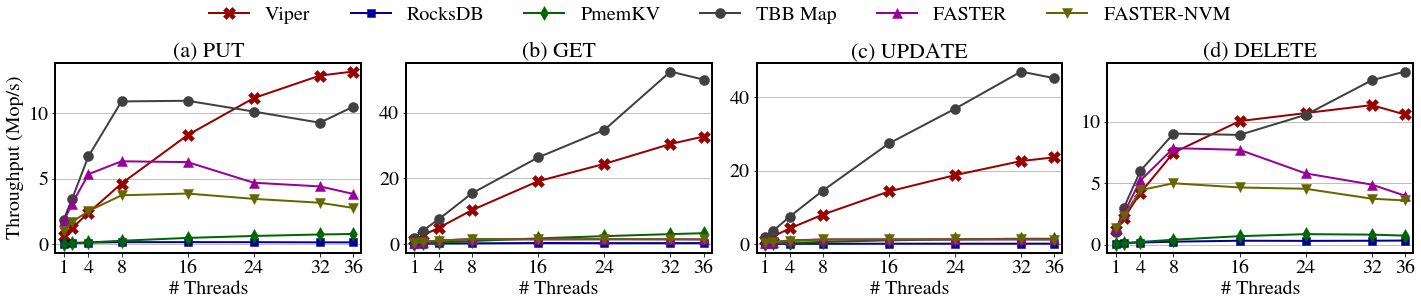

In [369]:
fig, (insert_ax, get_ax, update_ax, delete_ax) = plt.subplots(1, 4, figsize=(20, 4))


def get_bm_ax(bm_type):
    if bm_type == 'insert': return insert_ax
    if bm_type == 'get': return get_ax
    if bm_type == 'update': return update_ax
    if bm_type == 'delete': return delete_ax
    raise RuntimeError(f"Unknown bm_type {bm_type}")

num_threads = sorted({run['threads'] for run in list(runs.values())[0]})

for bm_type, letter in zip(ALL_BM_TYPES, ['a', 'b', 'c', 'd']):
    ax = get_bm_ax(bm_type)
    ax.set_xlabel("# Threads", fontsize=20)
    ax.set_title(f"({letter}) {bm_type.upper()}", fontsize=22)
    for (fixture, _) in ALL_FIXTURES:
        r = [run['items_per_second'] / MILLION for run in runs[(fixture, bm_type)]]
        style = STYLES[fixture]
        ax.plot(num_threads, r, marker=style.marker, ms=style.marker_size, 
                color=style.color, markeredgewidth=0.5, lw=2)
    x_ticks = np.append(ax.get_xticks(), 36)
    ax.set_xticks([1, 4, 8, 16, 24, 32, 36])
    ax.set_xlim(0, 37)
    ax.grid(axis='y', which='major')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)


insert_ax.set_ylabel("Throughput (Mop/s)", fontsize=20)
insert_ax.set_title(f"(a) PUT", fontsize=22)

fig.legend(loc='upper center', labels=[f[1] for f in ALL_FIXTURES], 
           bbox_to_anchor=(0.5, 1.1), ncol=6, frameon=False, fontsize=20)

fig.savefig('charts/all_ops.pdf', bbox_inches='tight')
fig.savefig('charts/all_ops.svg', bbox_inches='tight')